In [1]:
%load_ext autoreload
%autoreload 2

import os


import sys

import scipy
import scipy.io
import time

import os.path
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE"


import tensorflow as tf
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "/home/vlq26735/code/PhD/GradientPathologiesPINNs/checkpoints/1DWave/"
MODE = "ntk"

src_path = os.path.abspath(os.path.join('../../'))
print(f"src_path= {src_path}")

if src_path not in sys.path:
    sys.path.insert(0, src_path)


# op_dir, log_file = common.make_output_dir(CHECKPOINT_PATH, MODE)
# print(f"op_dir = {op_dir} \nlog_file = {log_file}")

from src.cases.Wave import ntk


src_path= /home/vlq26735/code/PhD/GradientPathologiesPINNs


In [2]:

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y



# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) -  a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) -  a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)



In [3]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), name='coll')



nIter =1000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'ntk'
layers = [2, 5, 1]
starter_learning_rate = 1.0e-3

nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)


method =   "mini_batch"
activFun = "tanh"
starter_learning_rate = 1.0e-3



# [elapsed, error_u , model] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )
tf.reset_default_graph()
gpu_options = tf.GPUOptions(visible_device_list="0")
sess =  tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False))
# sess.run(init)

model = ntk.PINN(layers ,  ics_sampler, bcs_sampler, res_sampler, c , MODE , starter_learning_rate , CHECKPOINT_PATH , sess)

model.print("Using mode: " , model.mode)
model.print("neural network: " , model.layers )
model.print("Batch size : " ,kernel_size)

model.print("Activation function: " , activFun)
model.print("number of iterations: " , nIter)
model.print("starter_learning_rate: " , starter_learning_rate)

model.print("Method desciption : gradual learing rate , " ,  model.mode , ", with  " , method ," batch. ")

model.print("File directory: " , model.dirname)
sys.stdout.flush()
# Train model
start_time = time.time()

model.trainmb(nIter, mbbatch_size)
elapsed = time.time() - start_time

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
# Predictions

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(r_star, 2)

model.print('elapsed: {:.2e}'.format(elapsed))

model.print('Relative L2 error_u: {:.2e}'.format(error_u))
model.print('Relative L2 error_r: {:.2e}'.format(error_r))


model.print("file directory:" , model.dirname)
model.save_NN()
model.plot_grad()
model.plot_lambda()
model.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)
sys.stdout.flush()


2024-02-28 10:21:02.205292: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 10:21:02.254909: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2445400000 Hz
2024-02-28 10:21:02.255161: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fd6175f3a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-28 10:21:02.255174: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-28 10:21:02.255767: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


mini_batch method is used
It: 0| Loss: 2.742e+00| Loss_res: 1.434e+00|  Loss_bcs: 4.976e-01| Loss_ut_ics: 8.105e-01| Time: 22.18
mean_grad_res: 1.689e+00
mean_grad_ics: 5.123e-01
mean_grad_bcs: 3.982e-01


Compute NTK...


adaptive_constant_bcs_val: 1.2602e+02
adaptive_constant_ics_val: 1.7262e+02
adaptive_constant_res_val: 1.0139e+00
Gradients information stored ...
It: 100| Loss: 8.214e+01| Loss_res: 2.257e+00|  Loss_bcs: 3.583e-01| Loss_ut_ics: 2.010e-01| Time: 58.13
Gradients information stored ...
It: 200| Loss: 5.694e+01| Loss_res: 2.133e+00|  Loss_bcs: 3.399e-01| Loss_ut_ics: 6.920e-02| Time: 84.43
It: 300| Loss: 4.418e+01| Loss_res: 2.252e+00|  Loss_bcs: 2.990e-01| Loss_ut_ics: 2.447e-02| Time: 103.92
It: 400| Loss: 4.685e+01| Loss_res: 2.548e+00|  Loss_bcs: 3.370e-01| Loss_ut_ics: 1.043e-02| Time: 123.18
It: 500| Loss: 4.054e+01| Loss_res: 2.832e+00|  Loss_bcs: 2.915e-01| Loss_ut_ics: 5.452e-03| Time: 142.53


KeyboardInterrupt: 

In [4]:

elapsed = time.time() - start_time

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
# Predictions

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(u_star, 2)

model.print('elapsed: {:.2e}'.format(elapsed))

model.print('Relative L2 error_u: {:.2e}'.format(error_u))
model.print('Relative L2 error_r: {:.2e}'.format(error_r))

model.save_NN()
model.plot_grad()
model.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)


elapsed: 2.25e+02
Relative L2 error_u: 1.13e+00
Relative L2 error_r: 7.40e+00
Save uv NN parameters successfully in %s .../home/vlq26735/code/PhD/GradientPathologiesPINNs/checkpoints/1DWave/Feb-28-2024_10-21-02-257062_ntk
Final loss total loss: 4.219968e+01
Final loss loss_res: 2.847577e+00
Final loss loss_bcs: 3.011521e-01
Final loss loss_bc1: 4.315325e-02
Final loss loss_bc2: 3.028013e-02
Final loss loss_ics_u: 2.277187e-01
Final loss loss_ics_u_t: 7.881271e-03


In [ ]:


# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
# Predictions

In [23]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star.flatten()[:,None] - r_pred, 2) / np.linalg.norm(u_star, 2)

In [24]:
r_star.flatten()[:,None].shape

(40000, 1)

In [25]:
# # Predictions
# u_pred = model.predict_u(X_star)
# r_pred = model.predict_r(X_star)
# # Predictions
# r_pred =r_pred.reshape(200,200)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
# error_r = np.linalg.norm(r_star - r_pred, 2)# / np.linalg.norm(r_star, 2)

# print('elapsed: {:.2e}'.format(elapsed))

print('Relative L2 error_u: {:.2e}'.format(error_u))
# print('Relative L2 error_r: {:.2e}'.format(error_r))
# r_pred =r_pred.reshape(200,200)


Relative L2 error_u: 7.15e-01


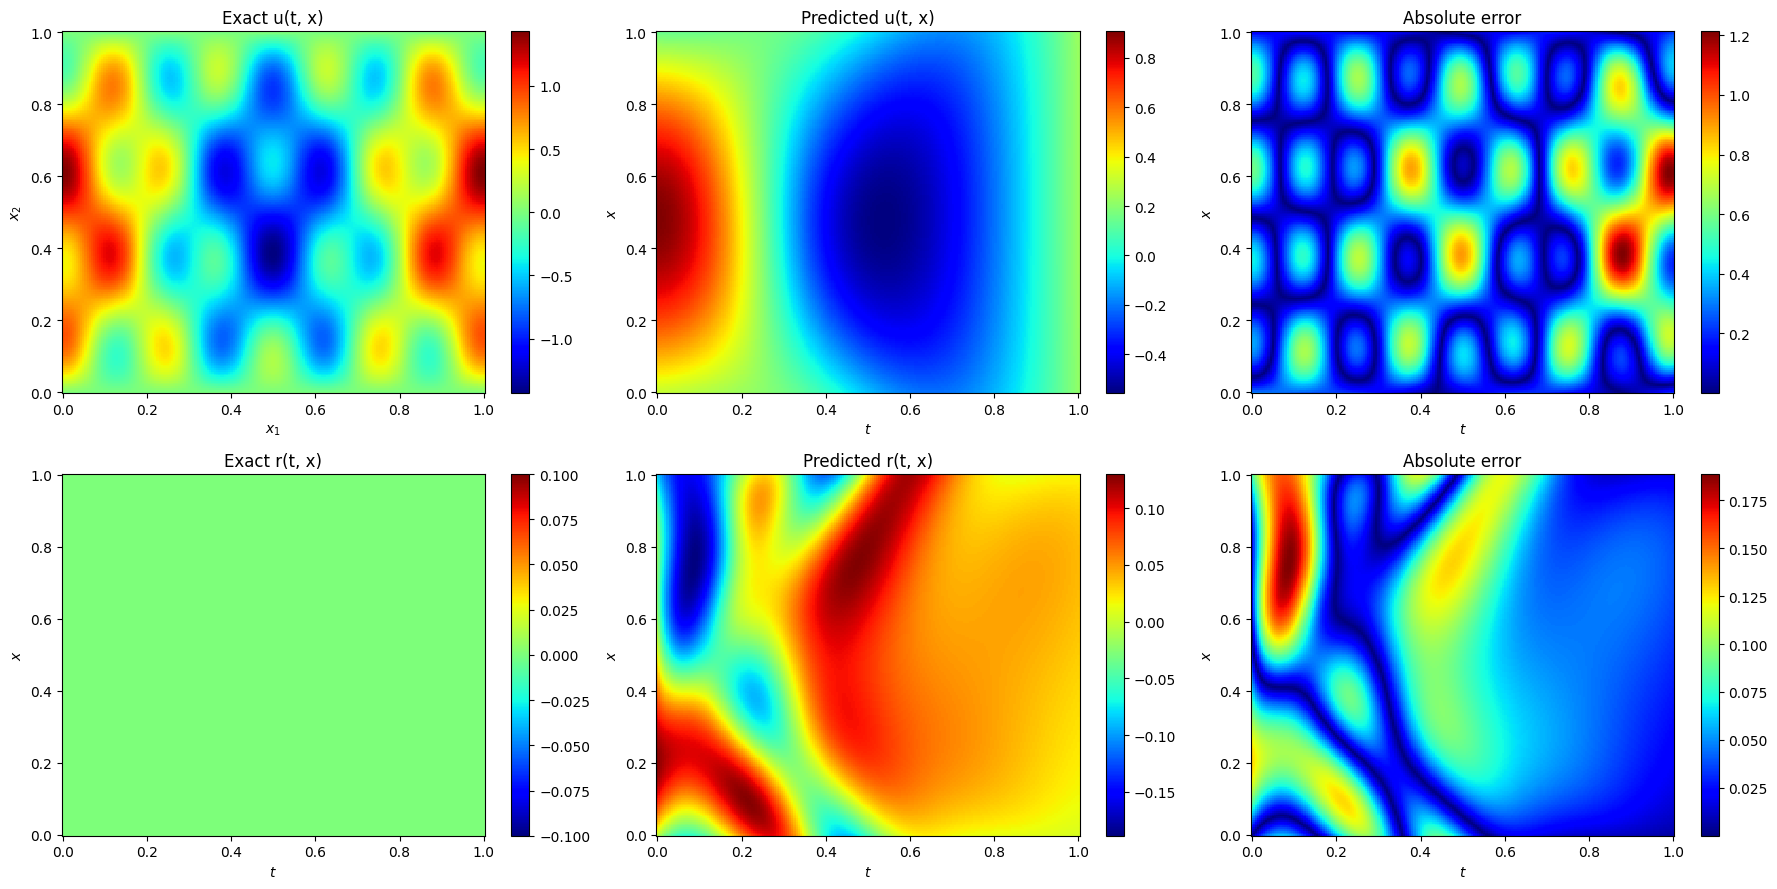

In [27]:

U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()